In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report
from scipy.stats import pearsonr
from utils import de_score
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scanpypip.utils import get_de_dataframe

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ranksums,ttest_ind


c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the umap, the performance score, and the predictive gene module score correlation. Require input is the h5ad file of the transfer learning
    
</div>  

# Set parameters of scanpy

In [2]:
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

Input h5ad of trained datasets

In [40]:
# List all files in the directoty
h5ad_list = glob.glob("save/adata/*.h5ad")

In [41]:
h5ad_list

['save/adata\\GSE110894integrate_data_GSE110894_drug_I.BET.762_bottle_512_edim_256,128_pdim_128,64_model_VAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_upsampling.h5ad',
 'save/adata\\GSE112274integrate_data_GSE112274_drug_GEFITINIB_bottle_256_edim_512,256_pdim_256,128_model_VAE_dropout_0.1_gene_F_lr_0.5_mod_new_sam_no.h5ad',
 'save/adata\\GSE117872_HN120integrate_data_GSE117872_HN120_drug_CISPLATIN_bottle_512_edim_256,128_pdim_128,64_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_SMOTE.h5ad',
 'save/adata\\GSE117872_HN137integrate_data_GSE117872_HN137_drug_CISPLATIN_bottle_256_edim_512,256_pdim_256,128_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad',
 'save/adata\\GSE140440integrate_data_GSE140440_drug_DOCETAXEL_bottle_512_edim_256,128_pdim_256,128_model_VAE_dropout_0.1_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad',
 'save/adata\\GSE149383integrate_data_GSE149383_drug_ERLOTINIB_bottle_512_edim_512,256_pdim_256,128_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsamplin

Define cell type column name in the meta data file of each dataset

In [42]:
CELL_TYPE_KEY = {"GSE117872_HN137":"cell_color","GSE117872_HN120":"cell_color","GSE110894":"Sample name","GSE140440":"sensitivity","GSE112274":"sensitivity",
                "GSE149383":"sensitivity"}

Select data set of interested

In [43]:
h5ad_list = [h5ad_list[3]]

In [44]:
h5ad_list

['save/adata\\GSE117872_HN137integrate_data_GSE117872_HN137_drug_CISPLATIN_bottle_256_edim_512,256_pdim_256,128_model_VAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_upsampling.h5ad']

In [45]:
intested = "GSE117872_HN137"

# Generated 3 figures comparing before, after tarnsfer, ground truth

And it will save the F1 score before and after the transfer learning

In [46]:
# Random score test
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [47]:
# Functioin to show p value on the figure
def p_string(l,score):
    score = sum(l>=score)/len(l)
    if(score==0):
        return "p < 0.001"
    else:
        return "p =" + " "+str(score)

# Show the prediction probability before transfer and after on UMAP

Index(['cell_color', 'patient_id', 'origin', 'drug_status', 'cluster',
       'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive',
       'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt-',
       'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps',
       'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin',
       'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label',
       'rest_preds'],
      dtype='object')



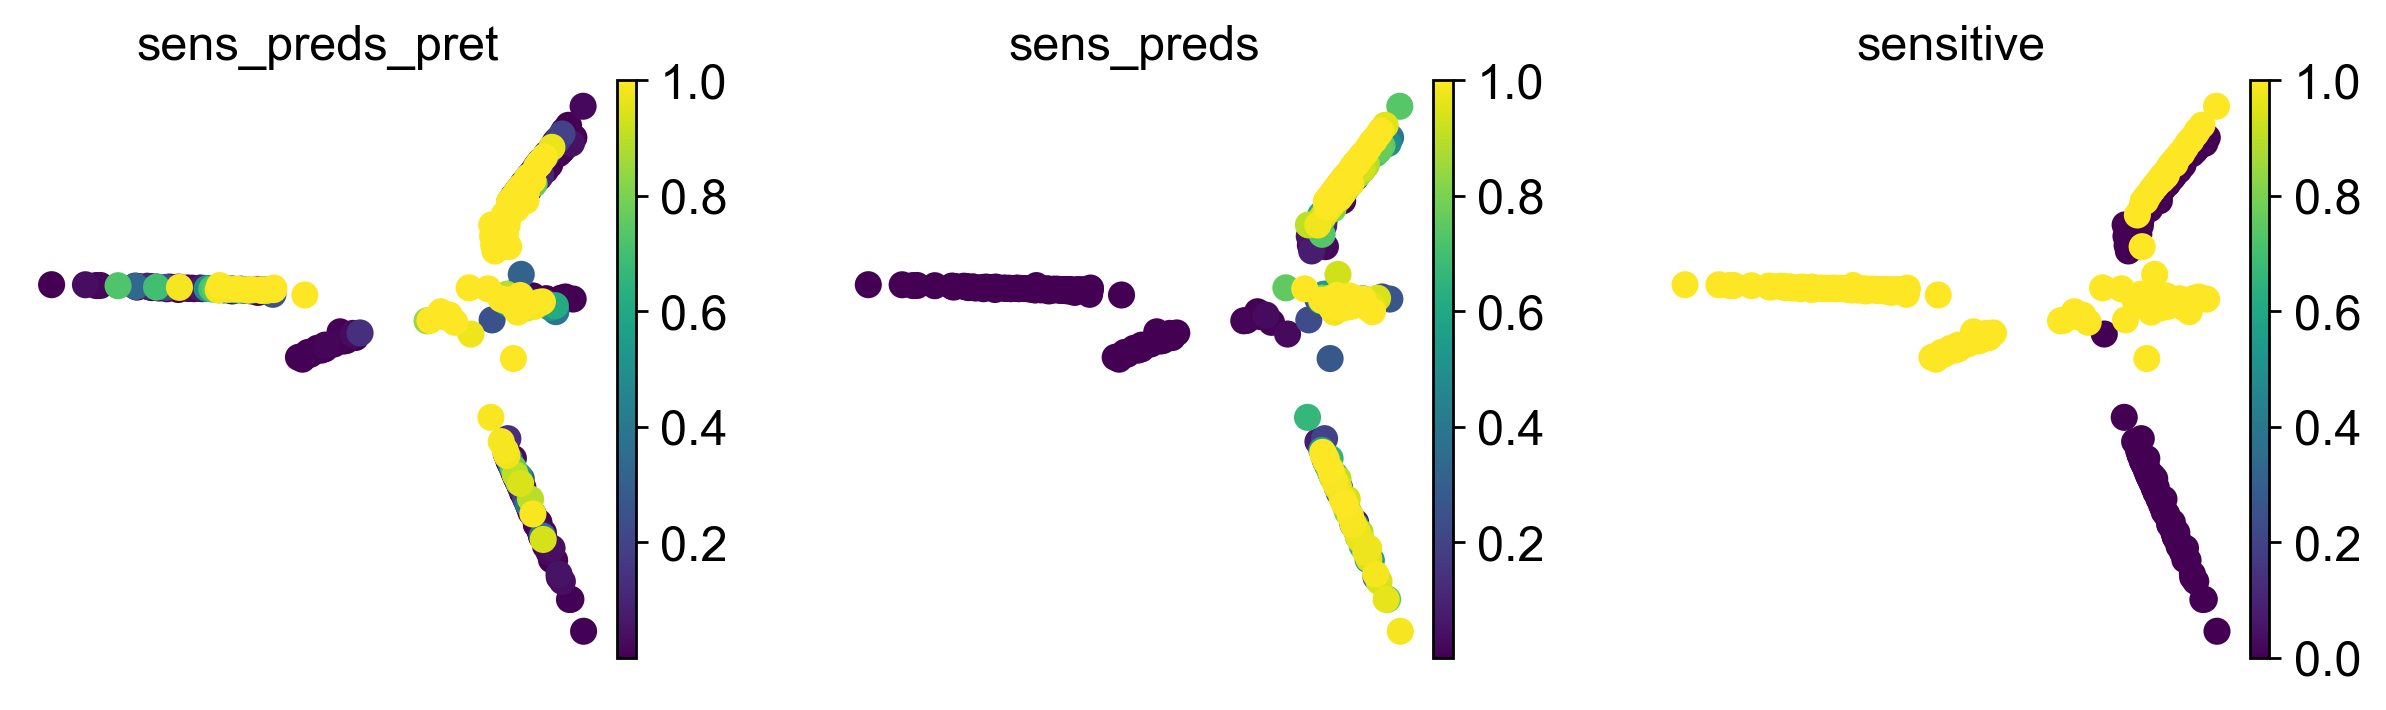

In [48]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

interes_adata = None

for f in h5ad_list:
    
    
    adata = sc.read_h5ad(filename=f)
    adata.uns['log1p']["base"] = None
    
    if(f.find("117872")>0):
        adata = adata[adata.obs['cluster']!="Holiday"]

    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']
    
        
    print(adata.obs.columns)

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("\\")[1]
    # name = "GSE112274"
    
    if(name=="GSE112274"):
        adata=adata[(adata.obs["sensitivity"] != "EMPTY") & \
                    (adata.obs["sensitivity"] != "EMPTY ") ,: ]
    
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    # Save the figure
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.tiff')
    # Save the f1 score before and after
    result.to_csv("save/results"+name + '.csv')
    
    # Cal pred senstivie score
    adata = ut.de_score(adata,clustername='sens_label')
    
    if(f.find(intested)>0):
        interes_adata = adata

In [49]:
adata.obs

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds,0_score,1_score
RHH1479,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,10.874201,3,3,0.004184,0,0.944636,1,0.053163,-0.720119,1.354673
RHH1480,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,13.157948,3,3,0.001399,0,0.556644,1,0.459443,-0.111196,1.348386
RHH1481,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,12.184268,3,3,0.080895,0,0.914518,1,0.086539,-0.520511,1.313291
RHH1482,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,13.384471,3,3,0.001070,0,0.956246,1,0.041052,-0.486729,0.874482
RHH1483,HN137P,red,HN137,Primary,Sensitive,4,2,2,1,Sensitive,...,6.988271,2,2,1.000000,1,0.757593,1,0.204122,-0.361999,-0.353366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHH2171,HN137MCR,hotpink,HN137,Metastatic,Resistant,5,3,4,0,Resistant,...,9.199856,1,1,0.031501,0,0.990057,1,0.008656,0.019902,2.314792
RHH2172,HN137MCR,hotpink,HN137,Metastatic,Resistant,4,3,4,0,Resistant,...,9.218620,1,1,0.988812,1,0.796881,1,0.209252,-0.190781,0.389464
RHH2173,HN137MCR,hotpink,HN137,Metastatic,Resistant,5,4,4,0,Resistant,...,7.154696,1,1,0.000572,0,0.606665,1,0.404553,0.032241,0.807983
RHH2174,HN137MCR,hotpink,HN137,Metastatic,Resistant,5,4,4,0,Resistant,...,8.137231,1,1,0.000051,0,0.013337,0,0.987693,-0.704389,1.112556


In [50]:
interes_adata

AnnData object with n_obs × n_vars = 493 × 7384
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [51]:
adata=interes_adata

In [52]:
adata

AnnData object with n_obs × n_vars = 493 × 7384
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Compare the score before and after the transfer learning

In [53]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [54]:
result_compare

,data,transfer,score
0,GSE117872_HN137integrate_data_GSE117872_HN137_...,before,0.448394
1,GSE117872_HN137integrate_data_GSE117872_HN137_...,transfer,0.396345


# Plot the umap highlighting the wrong predictions

In [55]:
adata

AnnData object with n_obs × n_vars = 493 × 7384
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds', '0_score', '1_score'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [56]:
idx = adata.obs["sensitive"] != adata.obs["sens_label"]

In [57]:
adata.obs['wrong'] = pd.NA

In [58]:
adata.obs.loc[idx,'wrong'] = "Wrong"
adata.obs['wrong'] = adata.obs.wrong.astype('category')

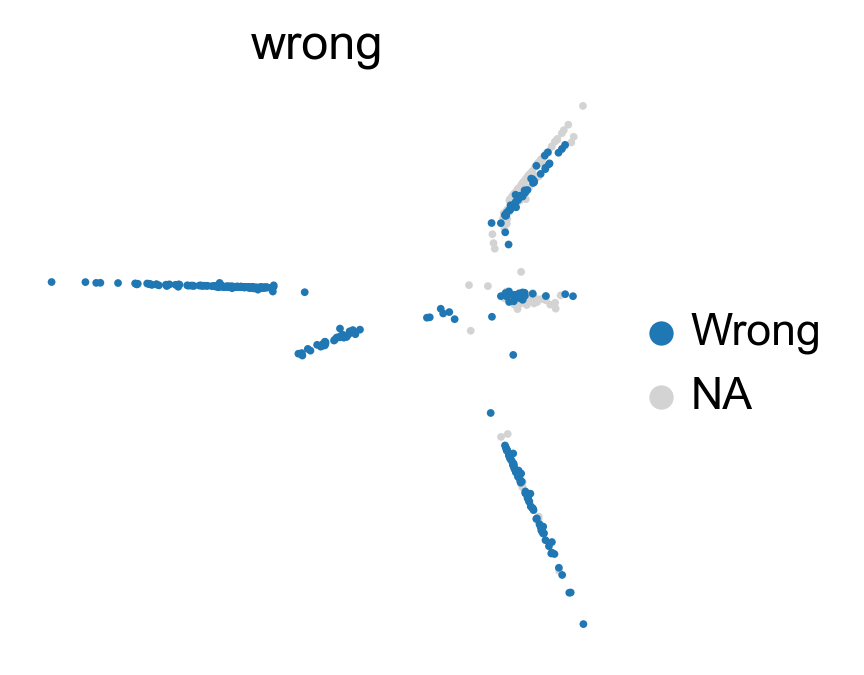

In [59]:
sc.pl.umap(adata,color="wrong",size=20)

In [60]:
name = intested

Calculate the numer of wrong predictions in each cell type

In [61]:
df = adata.obs[[CELL_TYPE_KEY[name],"wrong"]]\
.groupby([CELL_TYPE_KEY[name]])\
.aggregate(['count','size'])\
.reset_index()
df['data'] = name
df

cell_color wrong                  data
             count size                 
0     HN137M    25   75  GSE117872_HN137
1   HN137MCR    67   87  GSE117872_HN137
2     HN137P   174  253  GSE117872_HN137
3   HN137PCR    40   78  GSE117872_HN137

# Overview comparing the prediction and the ground Truth

In [62]:
adata.obs["pred_binary"] = adata.obs["sens_label"]
adata.obs.sens_label = adata.obs.sens_label.cat.rename_categories({1:"Sensitive", 0:"Resistant"})

In [63]:
adata.obs=adata.obs.rename(columns={"sensitivity": "Ground Truth", "sens_label": "Prediction"})

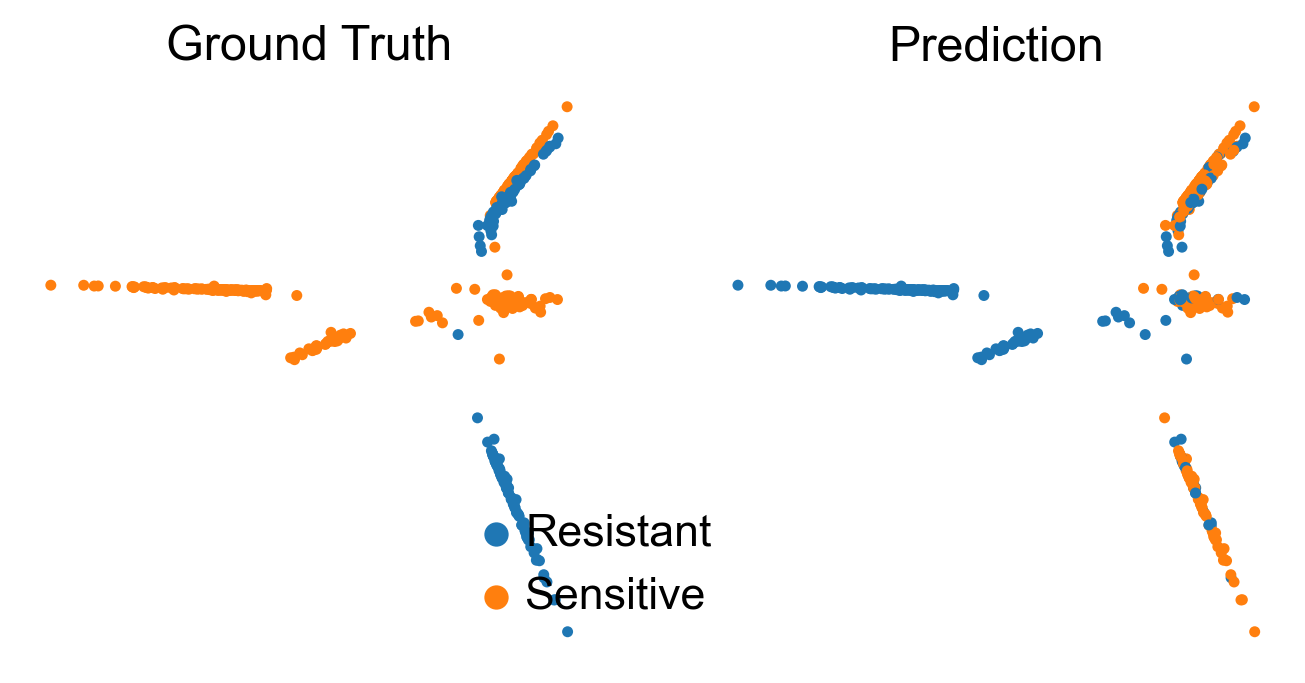

In [64]:
sc.settings.set_figure_params(dpi=250, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction"],size=40,show=False,wspace=0.1)
ax[0].legend().remove()
ax[1].legend(loc ='lower center',bbox_to_anchor=(-0.2, 0),frameon=False) 
plt.savefig("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/figures/figure2A_1"+name + ".tiff")

In [65]:
sens_preds_quantiles = []
for row in adata.obs.itertuples():
    sens_preds_quantiles.append(np.quantile([row.sens_preds,row.rest_preds],(0.025, 0.975)))
quantile_array = np.array(sens_preds_quantiles)
print('Lowest: ',np.min(quantile_array, axis=0))
print('Highest: ',np.max(quantile_array, axis=0))

Lowest:  [0.02500003 0.51461806]
Highest:  [0.50829913 0.975     ]


In [66]:
quantile_array.shape

(493, 2)

In [67]:
intested

'GSE117872_HN137'

In [68]:
latent_mu = pd.read_excel('save/bulk_f'+intested+'latent_mu.xlsx')

In [69]:
latent_mu

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,1.199026,0.054137,0.855570,1.335258,1.170098,-1.450029,-3.936631,1.542687,-5.881978,-1.521067,...,0.783397,0.143091,-1.910387,-1.480668,3.377109,4.696803,3.442434,1.872924,-0.014649,-2.792701
1,1.832687,-0.015794,0.012578,0.744027,1.483242,-0.723703,-4.235610,0.348855,-4.898166,-1.177862,...,2.382644,0.339649,-2.349045,-1.914308,2.061679,4.291483,2.577897,1.881699,0.322606,-1.673652
2,2.589542,-0.216663,1.764135,0.727144,1.271636,-1.018516,-4.493704,0.849738,-4.322969,-1.016813,...,0.753691,0.575601,-2.122132,-1.645394,2.143590,5.191528,3.467194,1.714002,-0.052646,-1.855453
3,1.189370,-0.021874,0.650275,0.875677,1.118896,-1.501072,-4.328039,1.300912,-5.977459,-1.122674,...,2.420168,0.274075,-2.107787,-1.665452,2.801331,4.511423,3.642272,2.360429,0.462170,-2.225635
4,-5.863013,2.950868,-3.988031,7.351178,-1.943776,-3.075107,-0.348359,6.509287,-18.834078,-9.120667,...,0.508934,-2.273128,-1.509899,-1.603185,14.724929,0.379129,1.979613,3.488939,-0.611811,-11.939529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,3.870384,-0.449435,2.451293,0.610030,1.336422,-0.800951,-4.329627,0.723218,-3.389429,-0.886565,...,-0.710738,0.676307,-1.989620,-1.492000,1.814153,4.980453,3.180574,1.436194,-0.881189,-1.735237
564,3.181365,-0.377716,2.150524,0.752546,1.285814,-0.816649,-4.017897,0.717870,-3.742040,-0.978836,...,-0.581861,0.611209,-1.863184,-1.316382,2.130623,4.547088,2.894741,1.320280,-0.783408,-1.958753
565,3.529381,-0.590937,2.176704,0.539836,0.975088,-0.583543,-3.604374,0.385592,-2.657106,-0.798707,...,-0.895997,0.621082,-1.734220,-1.253258,1.519772,3.985495,2.155600,0.842196,-1.159874,-1.476061
566,-1.754892,3.137031,0.079134,6.617736,1.161509,-1.851780,-4.032967,4.323874,-14.340237,-7.570073,...,0.539991,-1.003039,-1.694820,-0.717035,11.022052,4.726245,5.609039,3.263361,-0.938077,-9.359641


In [71]:
import umap
import umap.plot
%matplotlib inline
mapper = umap.UMAP(
    n_neighbors=15,
    min_dist=0.5,
    n_components=2,
    random_state=42).fit(latent_mu[:493])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


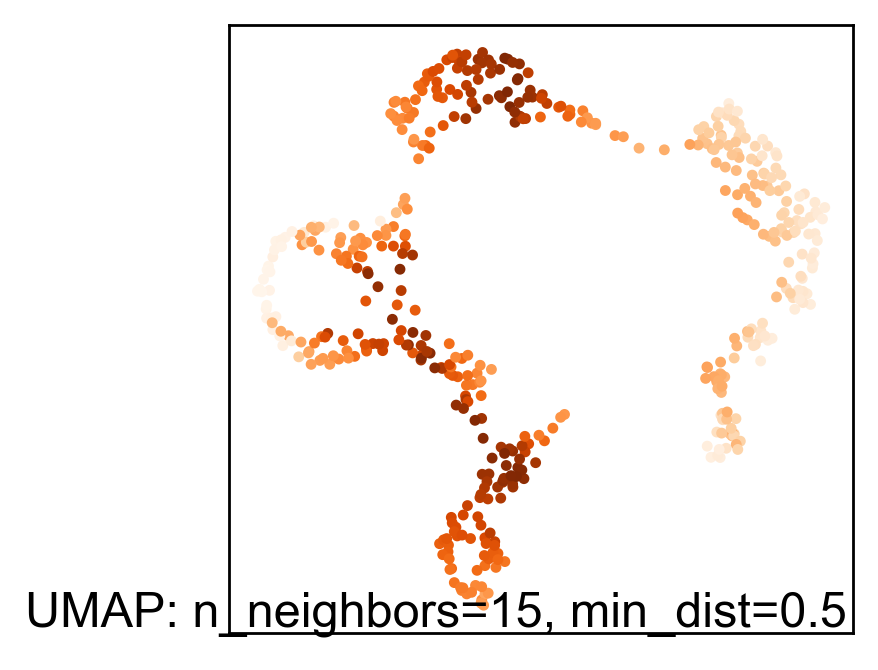

In [72]:
um_pl = umap.plot.points(mapper,labels=quantile_array[:,0],color_key_cmap='Oranges')
um_pl.legend().remove()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


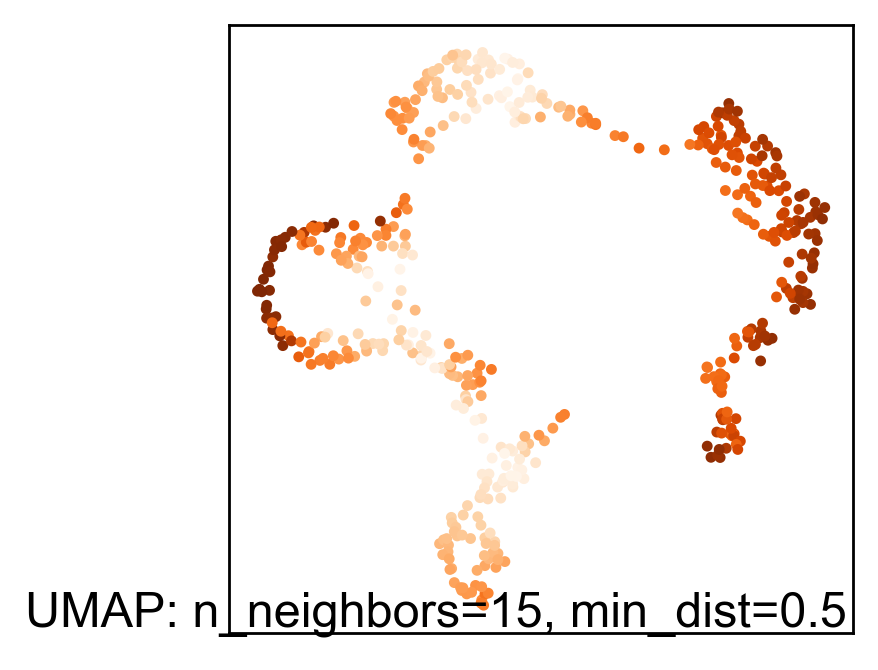

In [73]:
um_pl = umap.plot.points(mapper,labels=quantile_array[:,1],color_key_cmap='Oranges')
um_pl.legend().remove()

In [ ]:
plt.figure(figsize=(6, 4), dpi= 100)
umap.plot.diagnostic(mapper, diagnostic_type='neighborhood',cmap='Oranges')

<AxesSubplot:title={'center':'Colored by RGB coords of Vector Quantization'}>

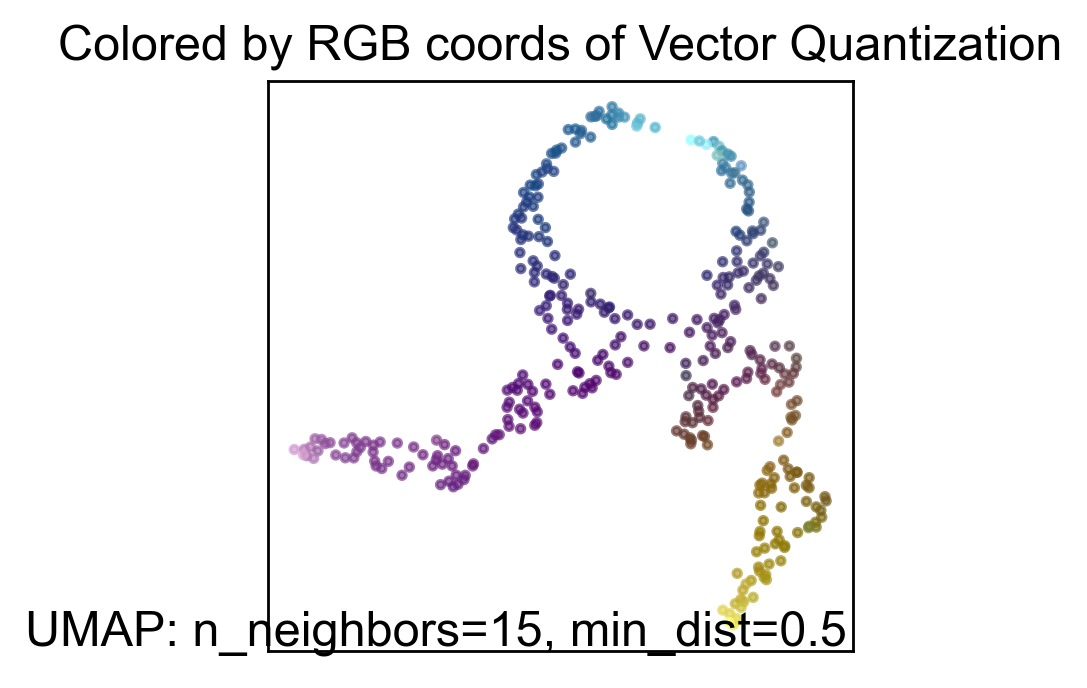

In [35]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

<AxesSubplot:>

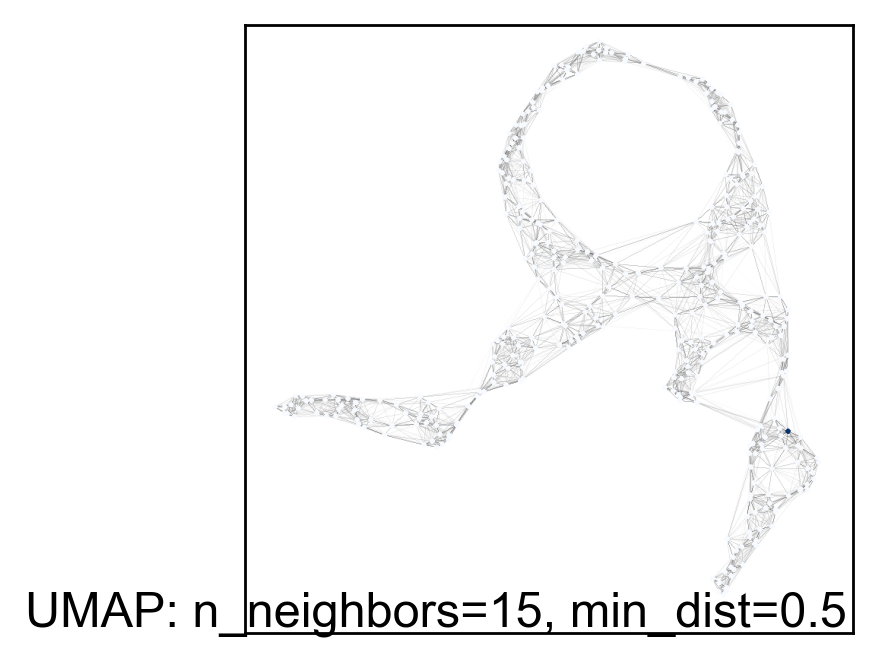

In [36]:
umap.plot.connectivity(mapper, show_points=True)

In [74]:
f1_df = pd.read_excel('save/bulk_f'+intested+'f1_scores.xlsx')
f1_df

,F1 Score,Lower Bound,Upper Bound
0,0.424466,0.411181,0.448719
1,0.417545,0.411181,0.448719
2,0.424943,0.411181,0.448719
3,0.414178,0.411181,0.448719
4,0.421434,0.411181,0.448719
...,...,...,...
995,0.436899,0.411181,0.448719
996,0.411624,0.411181,0.448719
997,0.453708,0.411181,0.448719
998,0.448899,0.411181,0.448719


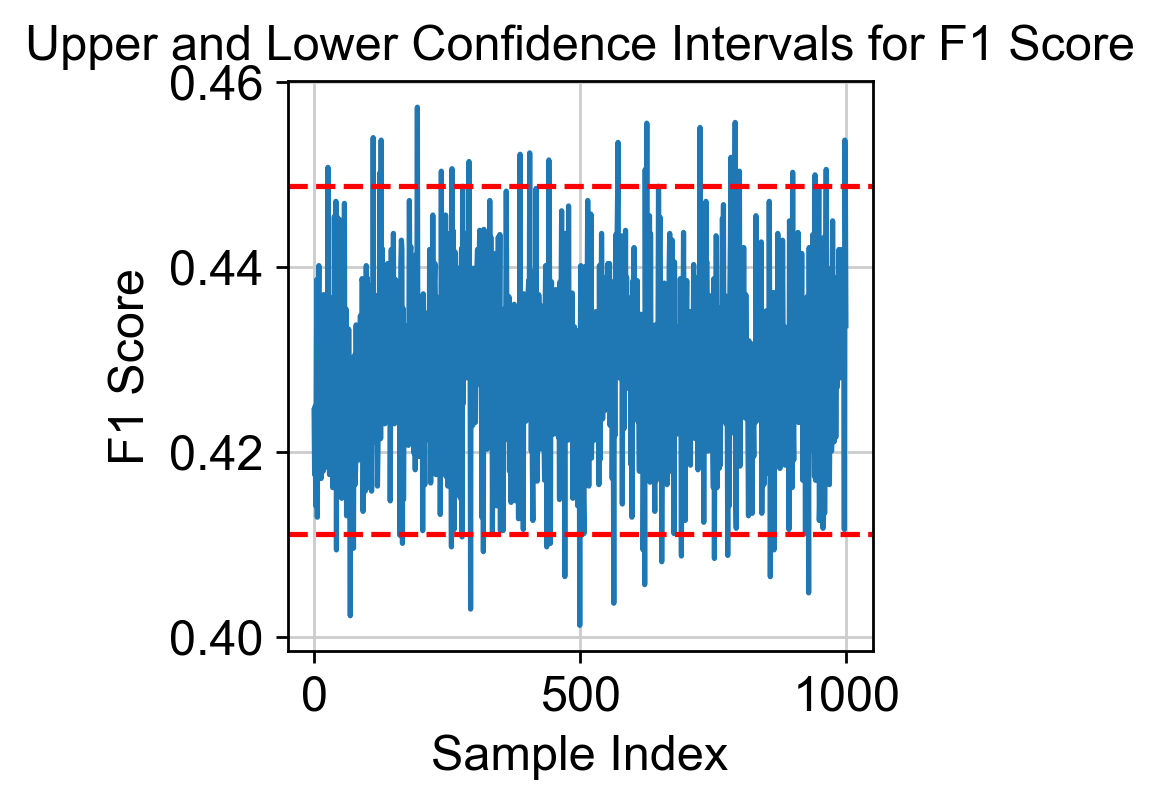

In [75]:
plt.plot(f1_df['F1 Score'])
plt.axhline(np.max(f1_df['Lower Bound']),linestyle = 'dashed', color = 'red')
plt.axhline(np.max(f1_df['Upper Bound']),linestyle = 'dashed', color = 'red')
plt.title('Upper and Lower Confidence Intervals for F1 Score')

# Optionally, you can add labels to the axes as well
plt.xlabel('Sample Index')
plt.ylabel('F1 Score')

# Show the plot
plt.show()

In [ ]:
try:
    adata.obs["Sample name"] = adata.obs["cell_color"]
except:
    adata.obs["Sample name"] = adata.obs["Ground Truth"]

# Show the prediction probablity of drug resistant

In [ ]:
ax = sc.pl.umap(adata,color=["sens_preds"],size=40,palette="Paired",show=False)
plt.savefig("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/figures/figure2A_2"+name + ".tiff")

In [ ]:
ax = sc.pl.umap(adata,color=["rest_preds"],size=40,palette="Paired",show=False)
plt.savefig("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/figures/figure2A_2"+name + ".tiff")

In [ ]:
adata.obs['sensitive']

In [ ]:
adata.obs["Sample name"]

In [ ]:
adata

# Show the cell type of the selected dataset

In [ ]:
# ax = sc.pl.umap(adata,color=["Sample name"],size=40,palette="Paired",show=False)
# # ax.legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
# plt.savefig("saved/figures/figure2A_3"+name + ".tiff")

In [ ]:
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction","Sample name"],size=25,palette="Paired",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[2].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.5)) 
#plt.savefig("figure2A_compare"+name + ".tiff")
plt.show()
plt.close()

# Show the gene module score of the sensitive and resistant cell clusters

The sensitive/resistant gene module score is the averaged expression score of the differently express genes within the sensitive/resistant cell cluster

In [ ]:
adata = ut.de_score(adata,clustername='pred_binary')

In [ ]:
sens_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
resistant_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])

In [ ]:
ax = sc.pl.umap(adata,color=["1_score","Sensitive_score"],size=40,palette="Set2",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("saved/figures/figure2A_4"+name + ".tiff")
plt.show()
plt.clf()

In [ ]:
ax = sc.pl.umap(adata,color=["0_score","Resistant_score"],size=40,palette="flare",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.55),frameon=False) 
#plt.savefig("saved/figures/figure2A_5"+name + ".tiff")
plt.show()
plt.clf()

# pval of the gene module score

In [ ]:
def ran_test_score(adata,n_iters=1000):
    ran_results1 = []
    ran_results2 = []

    s_score,s_pval = pearsonr(adata.obs["1_score"],adata.obs["Sensitive_score"])
    r_score,r_pval = pearsonr(adata.obs["0_score"],adata.obs["Resistant_score"])


    for i in range(0,n_iters):

        gl1 = random.sample(list(adata.var.index),50)
        adata=sc.tl.score_genes(adata, gene_list=gl1,score_name="l1_score",copy=True)

        rand_score1,rand_pval1 = pearsonr(adata.obs["l1_score"],adata.obs["Sensitive_score"])
        rand_score2,rand_pval2 = pearsonr(adata.obs["l1_score"],adata.obs["Resistant_score"])

        ran_results1.append(rand_score1)
        ran_results2.append(rand_score2)
        
        
    return adata,ran_results1, s_score,s_pval ,ran_results2,r_score,r_pval

In [ ]:
adata,s_ran, s_score,s_pval ,r_ran,r_score,r_pval = ran_test_score(adata,100)

In [ ]:
plt.hist(r_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(r_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(r_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(r_score), color='k')
plt.show()

In [ ]:
plt.hist(s_ran)
plt.xlim(xmin=-1, xmax = 1)
plt.axvline(s_score, color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(s_ran), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
#plt.text(-1, max_ylim*0.7, 'Mean: {:.2f}'.format(np.mean(r_ran)))
plt.text(-0.95, max_ylim*0.8, 'p < 0.001', color='k')
plt.text(-0.95, max_ylim*0.9, 'r: {:.2f}'.format(s_score), color='k')
plt.savefig("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/figures/random_senstive_gene"+name + '.svg')
plt.show()

# Show the correlation between the gene score and the prediction cell type

In [ ]:
import scipy as sp
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(style="whitegrid")

score_1 = adata.obs.loc[:,'Sensitive_score'].ravel()
score_2 = adata.obs.loc[:,'1_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values


scaler = MinMaxScaler()

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)
)

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
plt.show()
#plt.savefig("saved/figures/Regplot_sesistive_"+name+".tiff")
plt.clf()


In [ ]:
score_1 = adata.obs.loc[:,'Resistant_score'].ravel()
score_2 = adata.obs.loc[:,'0_score'].ravel()
c = adata.obs.loc[:,"Ground Truth"].values

# score_1 = np.clip(score_1,np.percentile(score_1, 5),np.percentile(score_1, 95))
# score_2 = np.clip(score_2,np.percentile(score_2, 5),np.percentile(score_2, 95))

DF_0 = pd.DataFrame({"Ground truth":score_1,"Prediction":score_2,"color":c})


r, p = sp.stats.pearsonr(score_1, score_2)

line_kws={'label':"r2={0:.3f}, pval={1:.2E}".format(r,p),"color":"red"}

sns.lmplot(x='Ground truth', y='Prediction', hue='color', data=DF_0, fit_reg=False, legend=False,scatter_kws={"s":20},\
           #palette=sns.color_palette("tab10_r",10)[8:10]
           palette=sns.color_palette("tab10",2)

)

# Use regplot to plot the regression line and use line_kws to set line label for legend
#ax = sns.regplot(x="x", y="y", data=DF_0, scatter_kws={"zorder":-1},

ax = sns.regplot(x=score_1, y=score_2,logx=False, line_kws=line_kws, scatter_kws={"zorder":-1,"s":20})
ax.legend(loc='upper left')
ax.figure.set_size_inches(4, 4)

sns.despine(left=False)
#plt.savefig("saved/figures/Regplot_resistant_"+name+".tiff")
plt.show()
plt.clf()

In [ ]:
r_pval